In [1]:
# Imports

import os
import random
import time

import cv2
import numpy as np
from tqdm import tqdm
import umap
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import Image as DisplayImage

In [2]:
number_of_frames = 2000 # Reduce the number of frames to lessen impact on memory
number_of_tvs = 10000 # Reduce the set of TVs so that it is digestable by UMAP

In [3]:
# Step 1. Grab a random assortment of frames from the movie

np.random.seed(42)

def random_frames_from_video(video_path, num_frames=5):
    """
    Extracts random frames from a video and returns them as a list of NumPy arrays.
    
    Parameters:
        video_path (str): Path to the video file.
        num_frames (int): Number of random frames to extract.
        
    Returns:
        list: NumPy array of NumPy arrays representing the frames.
    """
    # Open the video using OpenCV
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Check if the video file was opened successfully
    if not cap.isOpened():
        print("Error: Couldn't open the video file.")
        return []

    frames = []

    for _ in tqdm(range(num_frames), desc="Loading in video frames"):
        # Get a random frame number
        frame_num = random.randint(0, total_frames - 1)
        # Set the video position to the frame number
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
        # Read the frame
        ret, frame = cap.read()

        if ret:
            frames.append(frame)

    # Release the video capture object
    cap.release()

    # Convert frames to numpy array
    frames = np.array(frames)
    
    return frames

# Extract random frames from the video
frames = random_frames_from_video('cab_ride_trimmed.mkv', num_frames=number_of_frames)
width = frames.shape[1]
height = frames.shape[2]
random_indices = np.random.permutation(width * height) # for shuffling TVs later...

Loading in video frames: 100%|█████████████████████████████████████████████████████| 2000/2000 [03:17<00:00, 10.11it/s]


**TODO**: set this up so that instead of grabbing entire frames, we just grab the TVs so that way we can increase the number of frames we can use


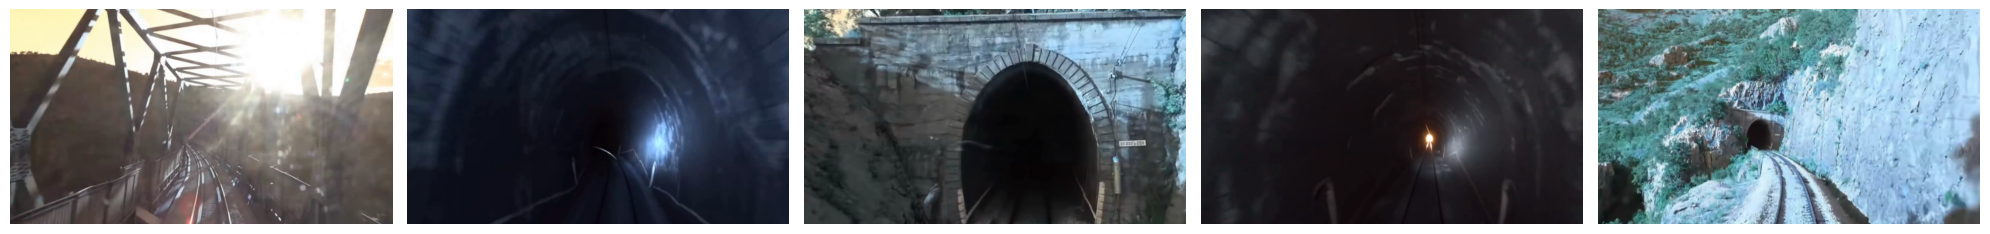

shape: (720, 1280, 3)


In [4]:
# Step 2: Preview a random sample of images

import matplotlib.pyplot as plt

# Display up to 5 frames
display_frames = frames[:5]

fig, axs = plt.subplots(1, len(display_frames), figsize=(20, 5))

for ax, frame in zip(axs, display_frames):
    ax.imshow(frame)
    ax.axis('off')

plt.tight_layout()
plt.show()
print("shape:", frames[0].shape)

In [5]:
# Step 3: Split each pixel position into its respective color series
# (AKA: TVs)

def pixel_color_series(x_position, y_position):
    return frames[:, x_position, y_position]

def tv(position):
    # select a random position so that there aren't any clues about where the TV goes
    position = random_indices[position]

    # convert to an x, y position
    x_position = position % width
    y_position = position // width
    return frames[:, x_position, y_position]

tvs = []
for i in tqdm(range(number_of_tvs), desc="Flattening tvs and turning them into a list"):
    tvs.append(tv(i).flatten())

del frames # clear out the frames, because by using flatten() we have created a copy
# note: ravel() might work to return a view instead of making a copy, try this later...

Flattening tvs and turning them into a list: 100%|█████████████████████████████| 10000/10000 [00:02<00:00, 4702.37it/s]


At this point, we now have each TV stored in the list <b><i>tvs</i></b>.

We should now be applying UMAP to the TVs!

In [6]:
n_neighbors = 150

In [7]:
# Step 4: Run UMAP

# Initialize UMAP with desired parameters
reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=0.1, n_components=2, metric='euclidean', n_jobs = -1, verbose = True)

# Fit and transform the data
embedding = reducer.fit_transform(tvs[:number_of_tvs])
x_coordinates, y_coordinates = embedding[:, 0], embedding[:, 1]


UMAP(n_neighbors=150, verbose=True)
Thu Sep 26 07:59:14 2024 Construct fuzzy simplicial set
Thu Sep 26 07:59:14 2024 Finding Nearest Neighbors
Thu Sep 26 07:59:14 2024 Building RP forest with 10 trees
Thu Sep 26 07:59:20 2024 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	Stopping threshold met -- exiting after 2 iterations
Thu Sep 26 08:00:57 2024 Finished Nearest Neighbor Search
Thu Sep 26 08:01:01 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Sep 26 08:01:14 2024 Finished embedding


In [8]:
# Step 5. Convert the TVs back into a nice "list of colors" format
# instead of a plain old list of values

def list_to_colors(input_list):
    '''
    Parameters:
        input_list: some list of numbers, like [1, 2, 3, 4, 5, 6]

    Returns:
        color_list: the input list chunked in threes, i.e.: [[1, 2, 3], [4, 5, 6]]
    '''
    if len(input_list) % 3 != 0:
        raise ValueError("The length of the list must be a multiple of 3.")
    return [tuple(input_list[i:i + 3]) for i in range(0, len(input_list), 3)]

relevant_tvs = []
for tv in tqdm(tvs[:number_of_tvs], desc = "Converting lists back to colors"):
    relevant_tvs.append(list_to_colors(tv))



Converting lists back to colors: 100%|██████████████████████████████████████████| 10000/10000 [00:24<00:00, 403.27it/s]


Loading animation: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.45it/s]


GIF created and saved as animation.gif


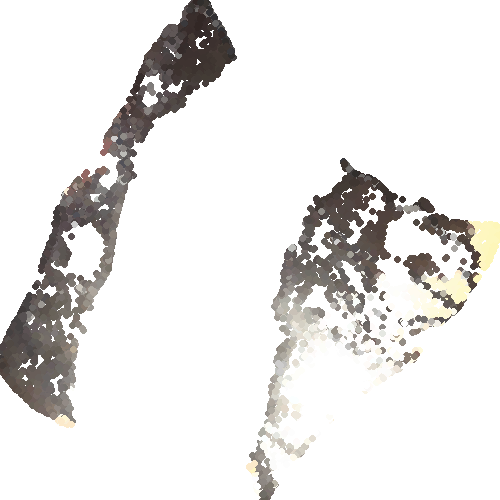

In [12]:
# Step 6. Create the animation

from PIL import Image, ImageDraw
import os
from tqdm import tqdm

def normalize_list(input_list):
    min_val = min(input_list)
    max_val = max(input_list)
    return [(x - min_val) / (max_val - min_val) for x in input_list]

def create_color_animation(color_list, x_list, y_list, output_filename='animation.gif', num_frames=None):
    # Set the image size and other parameters
    img_size = (500, 500)
    point_radius = 3  # Adjust point size as needed
    background_color = (255, 255, 255)  # White background
    x_list, y_list = normalize_list(x_list), normalize_list(y_list)
    
    if not num_frames:
        num_frames = len(color_list[0])  # Determine the number of frames from color_list
    
    images = []
    
    # Loop through each frame to generate images
    for frame in tqdm(range(num_frames), desc="Loading animation"):
        # Create a blank image with white background
        img = Image.new('RGB', img_size, background_color)
        draw = ImageDraw.Draw(img)
        
        # Draw each point for the current frame
        for i in range(len(x_list)):
            # Convert x, y to pixel coordinates (scaled to fit the image size)
            x = int(x_list[i] * (img_size[0]))  # Assuming x_list ranges from 0 to 1
            y = int(y_list[i] * (img_size[1]))  # Assuming y_list ranges from 0 to 1
            
            # Get the color for the current frame
            color = tuple(map(int, color_list[i][frame]))  # Convert to RGB tuple
            
            # Draw the point as a circle
            draw.ellipse([x - point_radius, y - point_radius, x + point_radius, y + point_radius], fill=color)
        
        # Append the frame to the list of images
        images.append(img)
    
    # Create a GIF from the list of images
    images[0].save(output_filename, save_all=True, append_images=images[1:], duration=300, loop=0)
    
    print(f"GIF created and saved as {output_filename}")

# Call the function to create the GIF
create_color_animation(relevant_tvs, x_coordinates, y_coordinates, num_frames=10)

# Display the GIF
DisplayImage(filename='animation.gif')


The UMAP reconstruction is pretty stringy and clearly needs some work...

In [13]:
# Step 7. Use a self-organizing map to get these points rectangular

import numpy as np
from minisom import MiniSom
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

def map_and_stretch_points(
    x_coordinates,
    y_coordinates,
    som_grid=(160, 90),
    target_resolution=(1280, 720),
    sigma=None,
    learning_rate=0.5,
    num_iterations=10000,
    random_seed=None
):
    """
    Maps original 2D points onto a SOM grid and scales them to a target resolution.

    Parameters:
    - x_coordinates (list or np.ndarray): List of x-coordinate values.
    - y_coordinates (list or np.ndarray): List of y-coordinate values.
    - som_grid (tuple): Dimensions of the SOM grid (width, height). Defaults to (160, 90).
    - target_resolution (tuple): Desired output resolution (width, height). Defaults to (1280, 720).
    - sigma (float, optional): Initial neighborhood radius. Defaults to max(som_grid)/2.
    - learning_rate (float, optional): Initial learning rate for SOM. Defaults to 0.5.
    - num_iterations (int, optional): Number of training iterations. Defaults to 10,000.
    - random_seed (int, optional): Seed for reproducibility. Defaults to None.

    Returns:
    - stretched_x (np.ndarray): Stretched x-coordinate values mapped to the target resolution.
    - stretched_y (np.ndarray): Stretched y-coordinate values mapped to the target resolution.
    - som (MiniSom): Trained SOM instance.
    """
    if random_seed is not None:
        np.random.seed(random_seed)

    # 1. Combine x and y coordinates into a single data array
    if len(x_coordinates) != len(y_coordinates):
        raise ValueError("x_coordinates and y_coordinates must have the same length.")
    
    data = np.column_stack((x_coordinates, y_coordinates))  # Shape: (num_points, 2)

    # 2. Normalize the data
    scaler = MinMaxScaler()
    data_normalized = scaler.fit_transform(data)

    # 3. Initialize and train the SOM
    som_width, som_height = som_grid
    if sigma is None:
        sigma = max(som_grid) / 2.0  # Default sigma

    som = MiniSom(
        x=som_width,
        y=som_height,
        input_len=2,
        sigma=sigma,
        learning_rate=learning_rate,
        topology='rectangular',
        random_seed=random_seed
    )

    # Initialize weights with the normalized data
    som.random_weights_init(data_normalized)
    print("Training SOM...")
    som.train_random(data_normalized, num_iterations)
    print("SOM training completed.")

    # 4. Map each data point to its BMU on the SOM grid
    mapped = np.array([som.winner(x) for x in data_normalized])  # Shape: (num_points, 2)

    # 5. Scale the BMU coordinates to the target resolution
    mapped_x = mapped[:, 0]
    mapped_y = mapped[:, 1]

    som_width, som_height = som_grid
    target_width, target_height = target_resolution

    # Compute scaling factors
    scale_x = target_width / som_width
    scale_y = target_height / som_height

    # Scale the BMU coordinates
    stretched_x = mapped_x * scale_x
    stretched_y = mapped_y * scale_y

    return stretched_x, stretched_y, som

stretched_x, stretched_y, som = map_and_stretch_points(x_coordinates, y_coordinates)

Training SOM...
SOM training completed.


Loading animation: 100%|█████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 36.69it/s]


GIF created and saved as stretched_animation.gif


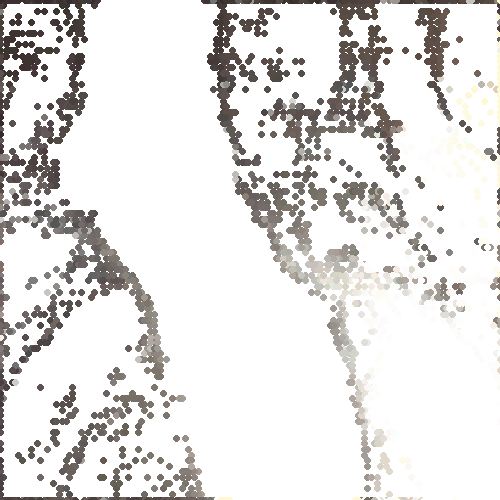

In [14]:
stretched_x = normalize_list(stretched_x)
stretched_y = normalize_list(stretched_y)

create_color_animation(relevant_tvs, stretched_x, stretched_y, output_filename = "stretched_animation.gif", num_frames = 100)

# Display the GIF
DisplayImage(filename='stretched_animation.gif')

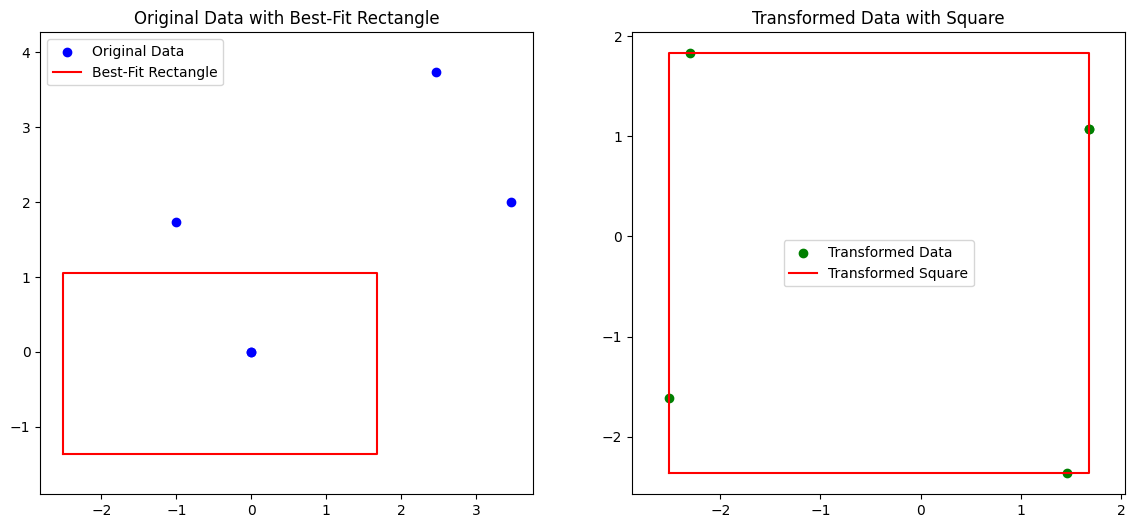

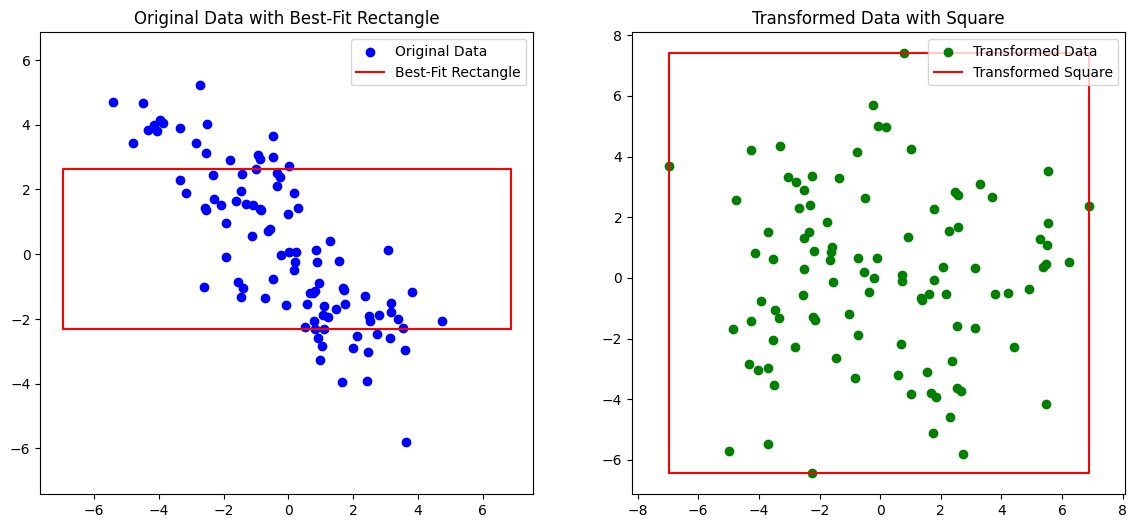

In [17]:
please modify so that in the end the square along with it points are rotated so that the square sits flatly

import numpy as np
import matplotlib.pyplot as plt

def rectangle_to_square_transformation(x_coordinates, y_coordinates):
    # Stack the coordinates into a 2D array
    data = np.vstack((x_coordinates, y_coordinates)).T

    # Center the data
    data_mean = np.mean(data, axis=0)
    data_centered = data - data_mean

    # Compute the covariance matrix
    cov_matrix = np.cov(data_centered.T)

    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

    # Sort the eigenvalues and eigenvectors in decreasing order
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    # Rotate the data to align with the principal components
    rotation_matrix = eigenvectors
    data_rotated = data_centered.dot(rotation_matrix)

    # Compute the bounding rectangle in the rotated space
    min_coords = np.min(data_rotated, axis=0)
    max_coords = np.max(data_rotated, axis=0)
    rectangle_corners = np.array([
        [min_coords[0], min_coords[1]],
        [max_coords[0], min_coords[1]],
        [max_coords[0], max_coords[1]],
        [min_coords[0], max_coords[1]],
        [min_coords[0], min_coords[1]],  # Close the rectangle
    ])

    # Stretch the data to make the rectangle a square
    range_x = max_coords[0] - min_coords[0]
    range_y = max_coords[1] - min_coords[1]
    scale_factor = range_x / range_y if range_y != 0 else 1
    data_stretched = data_rotated.copy()
    data_stretched[:, 1] *= scale_factor

    # Compute the square in the stretched space
    max_size = max(range_x, range_x)  # Since we scaled y to match x
    square_corners = np.array([
        [min_coords[0], min_coords[1] * scale_factor],
        [max_coords[0], min_coords[1] * scale_factor],
        [max_coords[0], max_coords[1] * scale_factor],
        [min_coords[0], max_coords[1] * scale_factor],
        [min_coords[0], min_coords[1] * scale_factor],  # Close the square
    ])

    # Rotate back to the original space
    data_rotated_back = data_rotated.dot(rotation_matrix.T) + data_mean
    data_stretched_back = data_stretched.dot(rotation_matrix.T) + data_mean

    # Rotate the rectangle corners back
    rectangle_corners_back = rectangle_corners.dot(rotation_matrix.T) + data_mean
    square_corners_back = square_corners.dot(rotation_matrix.T) + data_mean

    # Plotting
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # Original data and rectangle
    axs[0].scatter(x_coordinates, y_coordinates, color='blue', label='Original Data')
    axs[0].plot(rectangle_corners_back[:, 0], rectangle_corners_back[:, 1], 'r-', label='Best-Fit Rectangle')
    axs[0].set_title('Original Data with Best-Fit Rectangle')
    axs[0].legend()
    axs[0].axis('equal')

    # Transformed data and square
    axs[1].scatter(data_stretched_back[:, 0], data_stretched_back[:, 1], color='green', label='Transformed Data')
    axs[1].plot(square_corners_back[:, 0], square_corners_back[:, 1], 'r-', label='Transformed Square')
    axs[1].set_title('Transformed Data with Square')
    axs[1].legend()
    axs[1].axis('equal')

    plt.show()

# Testing the function
# Generate test data where y has greater spread than x, then rotate by 45 degrees
np.random.seed(0)
n_points = 100
x = np.random.normal(0, 1, n_points)
y = np.random.normal(0, 3, n_points)
data = np.vstack((x, y)).T

# Rotate data by 45 degrees
theta = np.radians(45)
c, s = np.cos(theta), np.sin(theta)
rotation_matrix = np.array([[c, -s], [s, c]])
data_rotated = data.dot(rotation_matrix.T)

x_rotated = data_rotated[:, 0]
y_rotated = data_rotated[:, 1]

# Call the transformation function
rectangle_to_square_transformation(x_rotated, y_rotated)